## Imports


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.base import clone
from sklearn.base import TransformerMixin

## Reading the file

In [109]:
df=pd.read_csv('final_data_Copy.csv')

In [110]:
df.shape

(3080, 18)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   m2                  3080 non-null   float64
 1   nb_rooms            3080 non-null   int64  
 2   nb_bedrooms         3080 non-null   int64  
 3   building_floor      3080 non-null   int64  
 4   apartment_floor     3080 non-null   int64  
 5   nb_bath             3080 non-null   int64  
 6   Cellar              3080 non-null   int64  
 7   balc_patio          3080 non-null   object 
 8   Heating             3080 non-null   object 
 9   Renovated           3080 non-null   int64  
 10  Parking             3080 non-null   int64  
 11  building_height     3080 non-null   object 
 12  Ground_floor        3080 non-null   int64  
 13  Heating_Central     3080 non-null   int64  
 14  Heating_Individual  3080 non-null   int64  
 15  Last_floor          3080 non-null   int64  
 16  distri

## What will we do ?
- Choose relevant columns
- get dummy data
- train test split
- multiple linear regression
- ridge regression
- random forest
- tune hyperparameters
- make predictions
- stacking

## Choose relevant columns

In [112]:
df.columns

Index(['m2', 'nb_rooms', 'nb_bedrooms', 'building_floor', 'apartment_floor',
       'nb_bath', 'Cellar', 'balc_patio', 'Heating', 'Renovated', 'Parking',
       'building_height', 'Ground_floor', 'Heating_Central',
       'Heating_Individual', 'Last_floor', 'district', 'SalePrice_K'],
      dtype='object')

In [113]:
df=df[['m2', 'nb_rooms','nb_bedrooms', 'building_floor',
       'apartment_floor', 'nb_bath', 'Cellar', 'balc_patio', 'Heating',
       'Renovated', 'Parking', 'SalePrice_K', 'building_height', 'Ground_floor',
       'Heating_Central', 'Heating_Individual', 'Last_floor', 'district']]

## Dealing with categorical variables

In [114]:
#get dummy data
df=pd.get_dummies(df)

In [115]:
df.shape

(3080, 53)

In [116]:
df.head()

,m2,nb_rooms,nb_bedrooms,building_floor,apartment_floor,nb_bath,Cellar,Renovated,Parking,SalePrice_K,...,district_1e,district_20e,district_2e,district_3e,district_4e,district_5e,district_6e,district_7e,district_8e,district_9e
0,3.496508,1,0,14,1,1,0,0,1,5.794841,...,0,0,0,0,0,0,0,0,0,0
1,4.804021,5,4,4,2,1,1,0,1,7.570443,...,0,0,0,0,1,0,0,0,0,0
2,4.219508,4,3,3,0,1,0,0,0,6.721426,...,0,0,0,0,0,0,0,0,0,0
3,3.583519,2,1,0,2,1,1,0,0,6.261492,...,0,0,0,0,0,0,0,0,0,0
4,3.465736,1,0,9,8,1,1,0,0,5.926926,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Data into a training and a testing set

In [117]:
#train test split
X=df.drop('SalePrice_K',axis=1)
y=df.SalePrice_K
X_train,X_test,y_train,y_test=train_test_split(X,y)


## Test 4 models with Cross validation without hyperparameters tuning

### Why did I decided to use Ridge and Lasso Regression?

The Least Squares estimator (Estimator in a Linear Regression) has the desired property of being unbiased. Sometimes, it happens at the cost of the variance, especially when the indepent variables are highly correlated.
When it happens, we should use regularizations techniques to reduce variance to the detriment of introducing more bias.

Ridge and Lasso regression are two regularization techniques to reduce the complexity of the model and prevent it to overfit (low bias/high variance).

- We prefer Lasso over Ridge when only a small number of predictors are significant.
- We use Ridge when a lot of predictors have a significant impact on the dependent variable.


### First let's define a function Root Mean Squared Error with Cross Validation Strategy

In [118]:
def rmse_cv(model):
    rmse=(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = 5))
    return rmse

In [119]:
#Linear Regression
lr=LinearRegression()
lr.fit(X_train,y_train)
score_lr=rmse_cv(lr)
print(f"\nLinear Regression score: {score_lr.mean()} ({score_lr.std()})\n")


Linear Regression score: 0.09546275616781907 (0.004807786960306017)



In [120]:
#Lasso
las=Lasso()
las.fit(X_train,y_train)
score_las=rmse_cv(las)
print(f"\nLinear Regression score: {score_las.mean()} ({score_las.std()})\n")


Linear Regression score: 0.5633238550832729 (0.018064092320102684)



In [121]:
#Ridge
rg=Ridge()
rg.fit(X_train,y_train)
score_rg=rmse_cv(rg)
print(f"\nRidge score: {score_rg.mean()} ({score_rg.std()})\n")


Ridge score: 0.09546655109472836 (0.004802568684507126)



In [122]:
#Random Forest
rf=RandomForestRegressor(n_jobs=-1)
rf.fit(X_train,y_train)
score_rf=rmse_cv(rf)
print(f"\nRandom Forest score: {score_rf.mean()} ({score_rf.std()})\n")


Random Forest score: 0.09738942702994854 (0.005745348187934066)



In [123]:
scores=pd.DataFrame(index=['Linear_Reg','Lasso','Ridge','Random_Forest'],data=[score_lr.mean(),score_las.mean(),score_rg.mean(),score_rf.mean()],columns=['score']).sort_values('score',ascending=False)

In [124]:
scores

,score
Lasso,0.563324
Random_Forest,0.097389
Ridge,0.095467
Linear_Reg,0.095463


## Hyperparameters tuning

In [21]:
#random forest
from sklearn.model_selection import GridSearchCV

parameters={'n_estimators':(100,200,300),
           'criterion':('mse','mae'),
           'max_features':['log2','sqrt',1,0.5],
           'min_samples_split':[2,3],
           'min_samples_leaf':[1,3,5,10,25]}

gs_rf=GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs_rf.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'criterion': ('mse', 'mae'),
                         'max_features': ['log2', 'sqrt', 1, 0.5],
                         'min_samples_leaf': [1, 3, 5, 10, 25],
                         'min_samples_split': [2, 3],
                         'n_estimators': (100, 200, 300)},
             scoring='neg_mean_absolute_error')

In [22]:
gs_rf.best_estimator_

RandomForestRegressor(criterion='mae', max_features=0.5, min_samples_split=3,
                      n_estimators=300, n_jobs=-1)

In [125]:
rf=RandomForestRegressor(criterion='mae', max_features=0.5, min_samples_split=3,
                      n_estimators=300, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(criterion='mae', max_features=0.5, min_samples_split=3,
                      n_estimators=300, n_jobs=-1)

Ridge(alpha=0.28)

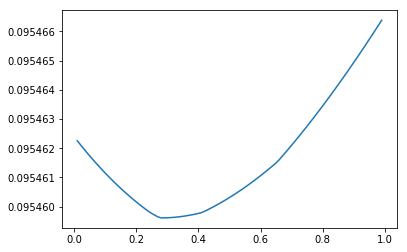

In [126]:
#Hyperparameters tuning
#Ridge
from operator import itemgetter
lr_rg=Ridge()
alpha=[]
error=[]
for i in range(1,100):
    alpha.append(i/100)
    lr_rg=Ridge(i/100)
    error.append(rmse_cv(lr_rg).mean())
    
plt.plot(alpha,error)
err=tuple(zip(alpha,error))

best_alpha=min(err, key=itemgetter(1))[0]   
rg=Ridge(alpha=best_alpha)
rg.fit(X_train,y_train)

Lasso(alpha=0.01)

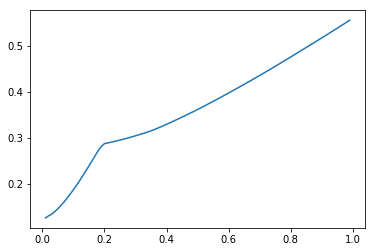

In [71]:
#Hyperparameters tuning
#Lasso
from operator import itemgetter
lr_las=Lasso()
alpha=[]
error=[]
for i in range(1,100):
    alpha.append(i/100)
    lr_las=Lasso(i/100)
    error.append(rmse_cv(lr_las).mean())
    
plt.plot(alpha,error)
err=tuple(zip(alpha,error))

best_alpha=min(err, key=itemgetter(1))[0]   
las=Lasso(alpha=best_alpha)
las.fit(X_train,y_train)

The best alpha is 0. Using Lasso with alpha=0 amount to the same thing as using a Linear Regression. Therefore, we will not use Lasso.

## Make predictions

In [127]:
preds_lr=lr.predict(X_test)
preds_rg=rg.predict(X_test)
preds_rf=rf.predict(X_test)

In [128]:
#Calculate the score of each model
scores_lr=mean_absolute_error(preds_lr,y_test)
scores_rg=mean_absolute_error(preds_rg,y_test)
scores_rf=mean_absolute_error(preds_rf,y_test)
scores=pd.DataFrame(index=['Linear_Reg','Ridge','Random_Forest'],data=[scores_lr,scores_rg,scores_rf],columns=['scores_tuned']).sort_values('scores_tuned')

In [129]:
#Calculate the score of each model in percentage of average saleprice of the apartments
scores_lr_pr=(mean_absolute_error(np.exp(preds_lr),np.exp(y_test)))/(np.mean(np.exp(y_test)))
scores_rg_pr=(mean_absolute_error(np.exp(preds_rg),np.exp(y_test)))/(np.mean(np.exp(y_test)))
scores_rf_pr=(mean_absolute_error(np.exp(preds_rf),np.exp(y_test)))/(np.mean(np.exp(y_test)))


In [131]:
#put the scores in a DataFrame
scores=pd.DataFrame({'scores':[scores_lr,scores_rg,scores_rf],'scores in percentage':[scores_lr_pr,scores_rg_pr,scores_rf_pr]})
scores= scores.rename(index={0:'Linear_Reg',1:'Ridge',2:'Random_Forest'}).sort_values('scores',ascending=False)
scores

,scores,scores in percentage
Random_Forest,0.098707,0.097521
Linear_Reg,0.096703,0.093664
Ridge,0.096693,0.093664


## Stacking

In [156]:
class WeightedAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        assert sum(self.weights)==10
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.sum(predictions*self.weights/10, axis=1)

In [177]:
weighted_average_model = WeightedAveragedModels(models = [lr,lr_rg,rf], weights=[2,3, 5])
weighted_average_model.fit(X_train,y_train)
preds_avg=weighted_average_model.predict(X_test)
scores_avg=mean_absolute_error(preds_avg,y_test)
scores_avg_pr=(mean_absolute_error(np.exp(preds_avg),np.exp(y_test)))/(np.mean(np.exp(y_test)))

In [178]:
final_scores=pd.DataFrame({'scores':[scores_lr,scores_rg,scores_rf,scores_avg],'scores in percentage':[scores_lr_pr,scores_rg_pr,scores_rf_pr,scores_avg_pr]})
final_scores= final_scores.rename(index={0:'Linear_Reg',1:'Ridge',2:'Random_Forest',3:'Weighted_average_model'}).sort_values('scores',ascending=False)
final_scores

,scores,scores in percentage
Random_Forest,0.098707,0.097521
Linear_Reg,0.096703,0.093664
Ridge,0.096693,0.093664
Weighted_average_model,0.093584,0.091808
